In [2]:
import pandas as pd

# Как читать решение

Весь код, для решения задачи предоставлен в файлах 


1_feature_making.ipynb  - формирование 3 фичей из выборок для разных периодов

2_preranking_fit.ipynb - обучение предварительного ранкера

3_ranking_fit.ipynb - обучение основного ранкера (hyperopt не вошел)

4_validate.ipynb - проверка качества решения на 10% данных

5_predict.ipynb - предсказание для тестовой выборки в формате организаторов

К сожалению, если вы не участвовали в соревновании, то сами выборки получить не получится.


В некоторые моменты может потребоваться до 128 Gb RAM. 
При желании думаю, что можно поместиться и в 64 Gb, но потребуется оптимизация.



## В данном файле решение будет представлено схематично.  
При возникновении вопросов можно детальнее посмотреть в любом из настоящих файлов (см выше).

# Описание задачи

В задаче необходимо было подобрать для каждого из 200 тысяч пользователей 20 лучших рекомендованных постов (из 100 тысяч постов), исключая уже просмотренные.
Фактически требовалось найти посты с наибольшим временем просмотра (просмотренный со временем 0 не считался положительным)

Данные в train были отсортированы по времени (хотя временный промежутки и не были указаны).
Я выбрал период предсказания в 5 млн последних записей в файле train_df и назвать это target_df

Так же решил обучаться только на тех пользователях, которые просматривали посты в этот период (target_df.user_id.unique())





In [5]:
full_df = pd.read_parquet('train.parquet.gzip')
train_df = full_df.iloc[:-5000000].reset_index(drop=True)
target_df = full_df.iloc[-5000000:].reset_index(drop=True)

print(train_df.shape)
print(target_df.user_id.nunique())
print(target_df.item_id.nunique())

(139440015, 4)
482302
148683


Если бы мы могли решать задачу как классическое ранжирование, то обучающая выборка составила бы несколько десятков миллиардов записей (для каждого user_id выбрать все доступные item_id) и проставить этим записям timespent.

Такими мощностями я не обдадал, поэтому решил как-то уменьшить эту обучающую выборку не сильно уменьшив recall.


# Лучшие item_id

Самая простая идея - взять наиболее "популярные" item_id. Которые посмотрело и много пользователей и крупные timespent. 
Это достигается простым суммированием, правда лучшее решение брать не общую сумму, а допустим за последние 5млн записей

Далее сделаем dataframe со всеми user_id и этими лучшими item_id
Recall такого подбора составил менее 10% для 72 млн записей.

In [8]:

# train_df.iloc[-5000000:].groupby('item_id')['timespent'].sum().sort_values(0, ascending = False).head(150)
best_150_df = pd.read_parquet('/srv/data/vk/train/best_150_df.parquet.gzip')
print(best_150_df.shape)
best_150_df.head()

(72345300, 2)


,user_id,item_id
0,594204,84951
1,786182,84951
2,211859,84951
3,222729,84951
4,511856,84951


In [10]:
count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_best150 = best_150_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_best150/count_positive_all
print(f'recall best items = {100*recall:.1f} %')

recall best items = 9.5 %


# ALS

какую бы гениальную систему рекомендаций мы не придумали - на исторических данных у рекомендательной системы, которая используется на бою будет преимущество (так как пользователь будет видеть рекомендации в ленте и хотя бы иногда изучать их).

поэтому, не смотря на то, что timespent = 0 не дает никаких преимуществ, хотелось бы сохранить какой-то бонус за их просмотр. Самое простое решение -  сделать таргет timespent+1

Небольшой тюнинг показал, что чем больше factors - тем лучше

Recall на 48 млн записей составил уже 25%

In [13]:
#user_item_rating_csr = sparse.coo_matrix((self.train_df["timespent"]+1,
#                                         (user_index, item_index)), shape=shape).tocsr()

feature_als_df = pd.read_parquet('/srv/data/vk/train/feature_als_512_15_df.parquet.gzip')
print(feature_als_df.shape)
feature_als_df.head()

count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_als = feature_als_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_als/count_positive_all
print(f'recall als 512 = {100*recall:.1f} %')

(48195800, 3)
recall als 512 = 25.1 %


# Использование векторов  для  item_id

Так как нам дали некие embedding вектора для каждого item_id, то стоит их попробовать использовать.

## Вариант 1:

    обучить als зафиксировав item_vectors на данных в качестве embedding

In [14]:
feature_emb_als_df = pd.read_parquet('/srv/data/vk/train/feature_emb_als_df.parquet.gzip')
print(feature_emb_als_df.shape)
feature_emb_als_df.head()

count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_als = feature_emb_als_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_als/count_positive_all
print(f'recall embedding als = {100*recall:.1f} %')

(9639160, 3)
recall embedding als = 2.1 %


## Вариант 2:

    обучить als зафиксировав item_vectors вначале, а потом "освободив"

In [18]:
feature_emb_als_tune_df = pd.read_parquet('/srv/data/vk/train/feature_emb_als_df_3_3.parquet.gzip')
print(feature_emb_als_tune_df.shape)
feature_emb_als_tune_df.head()

count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_als = feature_emb_als_tune_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_als/count_positive_all
print(f'recall embedding tune als = {100*recall:.1f} %')

(48195800, 3)
recall embedding tune als = 23.0 %


## Вариант 3:

    Использовать идею - посмотрел один пост, может посмотрит и похожий по cosine_similarity

In [19]:
feature_item_emb_cosine_df = pd.read_parquet('/srv/data/vk/train/feature_item_emb_cosine_df.parquet.gzip')

print(feature_item_emb_cosine_df.shape)

count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_als = feature_item_emb_cosine_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_als/count_positive_all
print(f'recall cosine embedding = {100*recall:.1f} %')

(154837146, 3)
recall cosine embedding = 13.6 %


# Источник source_id

Так же можно заметить, что user_id часто пользуются одним источником (автором?), поэтому чтобы поднять recall можно отобрать все item_id этого source_id. 
Но, к сожалению, такой подход дает слишком огномное количество кандидатов, поэтому нужно что-то сокращать. 

In [24]:
feature_source_user_df = pd.read_parquet('/srv/data/vk/train/feature_source_user_df.parquet.gzip')
feature_item_df = pd.read_parquet('/srv/data/vk/train/feature_item_df.parquet.gzip')
item_df = pd.read_parquet('items_meta.parquet.gzip')
item_source_dct = item_df.set_index('item_id')['source_id'].to_dict()
feature_item_df['source_id'] = feature_item_df['item_id'].map(item_source_dct)

tmp_df = train_df.iloc[-500000:].copy().reset_index(drop=True)
top_feature_item_df = feature_item_df[feature_item_df['item_id'].isin(
    tmp_df[tmp_df['timespent']>0]['item_id'].unique())]


full_train_item_df = feature_source_user_df[feature_source_user_df['good_sum']>0].merge(
    top_feature_item_df)

print(full_train_item_df.shape)

count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_source = full_train_item_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_source/count_positive_all
print(f'recall source = {100*recall:.1f} %')

(98055044, 14)
recall source = 21.3 %


# Посчитаем общий recall

Получились неплохие 46% при уменьшении обучающей в 340 раз (!!!)

In [25]:
%%time

input_df = pd.concat([best_150_df[['user_id','item_id']], 
                      full_train_item_df[['user_id','item_id']],
                      feature_als_df[['user_id','item_id']],
                      feature_emb_als_tune_df[['user_id','item_id']],
                      feature_emb_als_df[['user_id','item_id']],
                      feature_item_emb_cosine_df[['user_id','item_id']]]).drop_duplicates().reset_index(drop=True)

count_positive_all = target_df[target_df['timespent']>0].shape[0]
count_positive_union = input_df.merge(target_df[target_df['timespent']>0])[
    ['user_id','item_id']].drop_duplicates().shape[0]
recall = count_positive_union/count_positive_all
print(f'recall union = {100*recall:.1f} %')

recall union = 46.3 %
CPU times: user 2min 39s, sys: 13.7 s, total: 2min 53s
Wall time: 2min 53s


In [29]:
(input_df.user_id.nunique()*input_df.item_id.nunique())/input_df.shape[0]


339.30358772572555

# Обогащение фичами

Можно собрать общие статистики на item_id, на source_id, на пару source_id-user_id.
Почему-то я не собрал ни одной статистики на user_id (скорее всего тоже могло помочь)
В итоге получаем обычную обучающую выборку для ранкинга.

Правда строк около 360 млн записей.
А если откатиться еще на один период назад для стабильности - получится еще 360 млн.


In [31]:
sample_result_df = pd.read_parquet('/srv/data/vk/train/result_df_0.parquet.gzip')
sample_result_df.sample(5)

,user_id,item_id,source_id,cnt_users_by_item,mean_time_by_item,mean_good_by_item,mean_abs_react_by_item,pretarget_time_sum_5m,pretarget_time_sum_1m,pretarget_good_sum_5m,...,reaction_mean,reaction_abs_mean,reaction_abs_sum,als_score,emb_als_score,emb_als_score_tune,cosine,source_good_mean,source_good_sum,timespent
6814235,241801,20660,18665,1030,0.295146,0.202913,0.005825,34.0,6.0,20.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.908238,0.232897,160.0,0.0
20396138,725931,18290,3832,21752,1.490484,0.282181,0.017286,3679.0,814.0,704.0,...,0.0,0.0,0.0,0.100217,0.000000,0.0,0.000000,0.320166,154.0,0.0
14211418,504548,1042,7035,3569,0.528439,0.365088,0.055758,1886.0,343.0,1303.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.336213,506.0,0.0
581306,20104,179033,18753,730,0.386301,0.097260,0.001370,4.0,4.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.192825,86.0,0.0
12417664,442238,145417,20248,3655,2.157045,0.307798,0.002462,762.0,117.0,113.0,...,0.0,0.0,0.0,0.000000,0.007526,0.0,0.000000,0.301887,16.0,0.0


In [49]:
#Фичи:
features_desctiptions_dct = {
    'cnt_users_by_item':'Количество users, просмотревших этот item_id',
    'mean_time_by_item':'Среднее время просмотра этого item_id', 
    'mean_good_by_item':'Как часто время было > 0 у этого item_id', 
    'mean_abs_react_by_item':'Средняя реакция (лайк/дизлайк) у этого item_id', 
    'pretarget_time_sum_5m':'Сумма timespent для этого item_id за последние 5млн записей в train', 
    'pretarget_time_sum_1m':'Сумма timespent для этого item_id за последние 1млн записей в train',
    'pretarget_good_sum_5m':'Количество положительных timespent для этого item_id за последние 5млн записей в train', 
    'pretarget_good_sum_1m':'Количество положительных timespent для этого item_id за последние 1млн записей в train',  
    'pretarget_prc':'Соотношение последнего 1 млн записей и 5 млн записей (отражает динамику)',
    'cnt_items': 'Количество item_id, просмотренных user_id у этого source_id', 
    'time_sum':'Количество времени, потраченного user_id у этого source_id', 
    'good_mean':'% положительных timespent в просмотренных item_id этого source_id для конкретного user_id', 
    'good_sum':'количество положительных timespent в просмотренных item_id этого source_id для конкретного user_id', 
    'reaction_mean':'средняя оценка (лайк/дизлайк/0) в просмотренных item_id этого source_id для конкретного user_id',
    'reaction_abs_mean':'среднее наличие оценки (лайк/дизлайк) в просмотренных item_id этого source_id для конкретного user_id', 
    'reaction_abs_sum':'количество оценок (лайк/дизлайк) в просмотренных item_id этого source_id для конкретного user_id', 
    'als_score':'score обычного als', 
    'emb_als_score':'score als на embedding векторах', 
    'emb_als_score_tune':'score als на tuned embedding векторах', 
    'cosine':'лучшая косинусная мера близости с уже просмотренными item_id для каждого user_id', 
    'source_good_mean':'Процент положительных timespent для этого source_id',
    'source_good_sum':'Количество положительных timespent для этого source_id'
}

# Идея предварительного ранкинга

Давайте построим простой ранкер (не переобученный) для предварительной разметки и обучим его на 20% выборки (чтобы влезло в оперативку)



In [ ]:
result_df = result_df.sort_values('user_id').reset_index(drop=True)
group_pretrain = result_df.groupby('user_id').size().reset_index(name='cnt').cnt.values

ranker_model = lgb.LGBMRanker(n_estimators = 20,
                         random_state = 33,
                         n_jobs = 8
                         )
ranker_model.fit(result_df[study_cols], 
          result_df['timespent'], 
          group=group_pretrain
         )

# Основной ранкинг

Будем идти пачками по 10% от всей выборки, подавать на вход предварительному ранкингу и оставлять только лучшие 200 item_id для каждого user_id. Это позволит сократить выборку почти в 3 раза.

Будем строить его на 70% выборки, которые по объему будут уже влезать в оперативную память.

Этот ранкер уже обучим хорошо (подберем параметры по hyperopt)

In [ ]:
result_df = result_df.sort_values('user_id').reset_index(drop=True)
group_train = result_df.groupby('user_id').size().reset_index(name='cnt').cnt.values

ranker_full_model = lgb.LGBMRanker(n_estimators = 200,
                         learning_rate = 0.1,
                         random_state = 33,
                         n_jobs = 8,
                         colsample_bytree= 0.844,
                         max_depth= 48,
                         min_child_samples= 1500,
                         min_child_weight=0.00415,
                         min_split_gain= 0.0279,
                         num_leaves= 256,
                         reg_alpha= 0.3605,
                         reg_lambda= 0.4198,
                         subsample= 0.2429)

ranker_full_model.fit(result_df[study_cols], 
          result_df['timespent'], 
          group=group_train
         )

# Валидация

 Проверим на оставшихся 10%. 
 Надо понимать, что в нашей выборке изначально recall только 46% и посчитанный ndcg_score только по ней всегда будет выше, чем реальный.
 Для подбора параметров это не важно, но для общей корреляции public и локальной валидации хочется посчитать по всем возможным кандидатам.
 
Определенная корреляция локальной валидации и public leaderbord была, хотя и не очень хорошей: (см ниже)

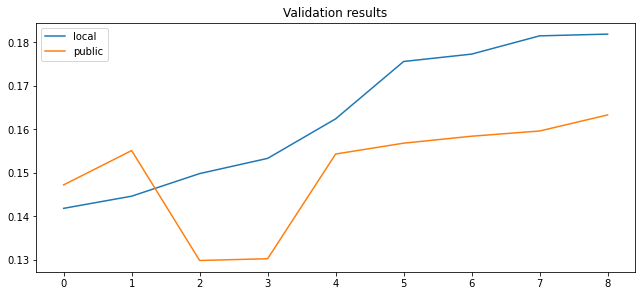

In [48]:
import matplotlib.pyplot as plt
import numpy as np

valid_df = pd.DataFrame({'local':np.array([1756,1446,1498,1418,1533,1815,1624,1773,1819])/10000,
              'public':np.array([1568,1551,1298,1472,1302,1596,1543,1584,1633])/10000}).sort_values(
    'local').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Validation results")


ax.plot(valid_df['local'], label = 'local')
ax.plot(valid_df['public'], label = 'public')
ax.legend()
plt.show()

# Итоги:

## решение заняло 2 место (0.164 public, 0.163 private, 0.182 local)


## Возможные улучшения:

    1. можно было лучше подбирать параметры под als, как одну из главнейших фич. Были результаты на 0.128 только на als
    2. можно было расчитать als_score для всей обучающей выборки. Правда возрастание кандидатов со 100 до 300 кандидатов не давало сильного прироста
    3. можно было добавить какие-то общие фичи именно для user_id (вряд ли много добавит)
    